In [1]:
import os 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [11]:
# load .csv from run 
# load .csv with ground truth 
# manually input below if running one video at a time 
# long term goal - incorporate into pipeline 

# video file path 
vid_in_path = r'..\..\tests\fixtures\all_videos\DS_HC_practice videos\RB_HC_gait_vertical_right.mov' # vid_in_path set during process_dir() of run.py

# run.py outputs
mp_all_filepath = r'..\..\temp\test_sandbox_pipeline_outputs\002_frames_to_time\RB_HC_gait_vertical_right_mediapipe_all_sec.csv'
yolo_filepath = r'..\..\temp\test_sandbox_pipeline_outputs\002_frames_to_time\RB_HC_gait_vertical_right_yolo_sec.csv' 

mp_all_df = pd.read_csv(mp_all_filepath, index_col = 0)
yolo_df = pd.read_csv(yolo_filepath, index_col = 0)

# ground truth anotation of turn start and stop time 
# watch videos frame by frame: e on keyboard = move forward one frame 
ground_truth_support_path = r'C:\Users\mmccu\Box\MM_Personal\5_Projects\BoveLab\3_Data_and_Code\poseEstimation_practice\data_example_videos\visual_annotation_ground_truth\vertical_double_support_frames.xlsx'
ground_truth_support_df = pd.read_excel(ground_truth_support_path, sheet_name = 'Sheet1', engine='openpyxl')

#filter ground truth for this specific participant 
ground_truth_support_df  = ground_truth_support_df.loc[ground_truth_support_df['filename'] == 'RB_HC_gait_vertical_right', :]
print(ground_truth_support_df.head())

# outputs 
output_parent_folder = r'..\..\temp\test_sandbox_pipeline_outputs\gait_events_test'

# filtering vars 
cutoff = 0.4  # Desired cutoff frequency of the filter in Hz
order = 1  # Order of the filter (higher means sharper cutoff)



                     filename subjectID                 task  \
31  RB_HC_gait_vertical_right     RB_HC  gait_vertical_right   
32  RB_HC_gait_vertical_right     RB_HC  gait_vertical_right   
33  RB_HC_gait_vertical_right     RB_HC  gait_vertical_right   
34  RB_HC_gait_vertical_right     RB_HC  gait_vertical_right   
35  RB_HC_gait_vertical_right     RB_HC  gait_vertical_right   

   walk_direction_num  fps  r_heel_strike_frames  QA_seconds  \
31             away_1   30                   121    4.033333   
32             away_1   30                   156    5.200000   
33             away_1   30                   188    6.266667   
34             away_1   30                   222    7.400000   
35           toward_1   30                   254    8.466667   

    frames between r heel strike and l toe off   l_toe_off_frames  \
31                                          6.0             127.0   
32                                          4.0             160.0   
33                     

In [12]:
def double_support_brainstorming_plots(pose_df, pose_df_name, ground_truth_support_df, vid_in_path, output_parent_folder):
    # from visual annotation 
    unique_directions =  ground_truth_support_df['walk_direction_num'].unique()

    for directions_i, current_direction in enumerate(unique_directions): 
        current_ground_truth_df = ground_truth_support_df.loc[ground_truth_support_df['walk_direction_num'] == current_direction] 
        print(directions_i)
        print(current_direction)

        # set toe off and heel strike vars 
        l_toe_off_frames = current_ground_truth_df['l_toe_off_frames']
        r_toe_off_frames = current_ground_truth_df['r_toe_off_frames']

        l_heel_strike_frames = current_ground_truth_df['l_heel_strike_frames']
        r_heel_strike_frames = current_ground_truth_df['r_heel_strike_frames']

        # Select left and right heel mediapipe markers 
        if pose_df_name == 'yolo': 
            # no heel marker, only ankle in yolo 
            heel_l_df = pose_df.loc[(pose_df['label'] == 'left_ankle')]
            heel_r_df = pose_df.loc[(pose_df['label'] == 'right_ankle')]
            landmark = 'ankle'
        elif pose_df_name == 'mediapipe': 
            heel_l_df = pose_df.loc[(pose_df['label'] == 'left_heel')]
            heel_r_df = pose_df.loc[(pose_df['label'] == 'right_heel')]
            landmark = 'heel'

        # set frame as an index to subtract each frame 
        heel_l_df.index = heel_l_df['frame']
        heel_r_df.index = heel_r_df['frame']

        # take heel data from subsection of walk in ground truth - full walk hard to see on plot 
        max_frame = max(max(l_toe_off_frames), max(r_toe_off_frames), max(l_heel_strike_frames), max(r_heel_strike_frames))
        min_frame = min(min(l_toe_off_frames), min(r_toe_off_frames), min(l_heel_strike_frames), min(r_heel_strike_frames))

        heel_l_df_2 = heel_l_df.loc[(heel_l_df['frame'] <= max_frame) & (heel_l_df['frame'] >= min_frame), :]
        heel_r_df_2 = heel_r_df.loc[(heel_r_df['frame'] <= max_frame) & (heel_r_df['frame'] >= min_frame), :]

        # get max and min for ylim of plot 
        if pose_df_name == 'yolo': 
            column_name = 'Y_negative'
        elif pose_df_name == 'mediapipe': 
            column_name = 'Y_pose_negative'
            
        max_y = max(max(heel_l_df_2[column_name]), max(heel_r_df_2[column_name]))
        min_y = min(min(heel_l_df_2[column_name]), min(heel_r_df_2[column_name]))

        # plot mediapipe pose Y vs frames 
        # plot Y vs frames 
        if pose_df_name == 'yolo': 
             y_label = 'Yolo Pixels: ' + column_name
        elif pose_df_name == 'mediapipe': 
            y_label = 'MP Pose: ' + column_name
        
        fig1, (ax1, ax2) = plt.subplots(2, figsize=(12, 6))
        fig1.suptitle(os.path.basename(vid_in_path) + ": " + current_direction)

        ax1.plot(heel_l_df_2['frame'], heel_l_df_2[column_name], color = 'black', label = 'l_' + landmark)
        ax1.vlines(x = l_toe_off_frames, ymin = min_y, ymax = max_y, color = 'blue', label = 'l_toe_off_frames')
        ax1.vlines(x = l_heel_strike_frames, ymin = min_y, ymax = max_y, color = 'orange', label = 'l_heel_strike_frames')
        ax1.set_ylabel(y_label)
        ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  

        ax2.plot(heel_r_df_2['frame'], heel_r_df_2[column_name], color = 'black', label = 'r_' + landmark)
        ax2.vlines(x = r_toe_off_frames, ymin = min_y, ymax = max_y, color = 'blue', label = 'r_toe_off_frames')
        ax2.vlines(x = r_heel_strike_frames, ymin = min_y, ymax = max_y, color = 'orange', label = 'r_heel_strike_frames')
        ax2.set_ylabel(y_label)
        ax2.set_xlabel('Frames')
        ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        # save figure 
        basename_no_ext =  os.path.splitext(os.path.basename(vid_in_path))[0]
        if pose_df_name == 'yolo': 
             output_path = os.path.normpath(os.path.join(output_parent_folder, basename_no_ext + '_' + current_direction + '_double_support_yolo.png'))
        elif pose_df_name == 'mediapipe': 
             output_path = os.path.normpath(os.path.join(output_parent_folder, basename_no_ext + '_' + current_direction + '_double_support_mp.png'))   
            
        fig1.savefig(output_path, bbox_inches = 'tight')
    

0
away_1
1
toward_1
0
away_1
1
toward_1


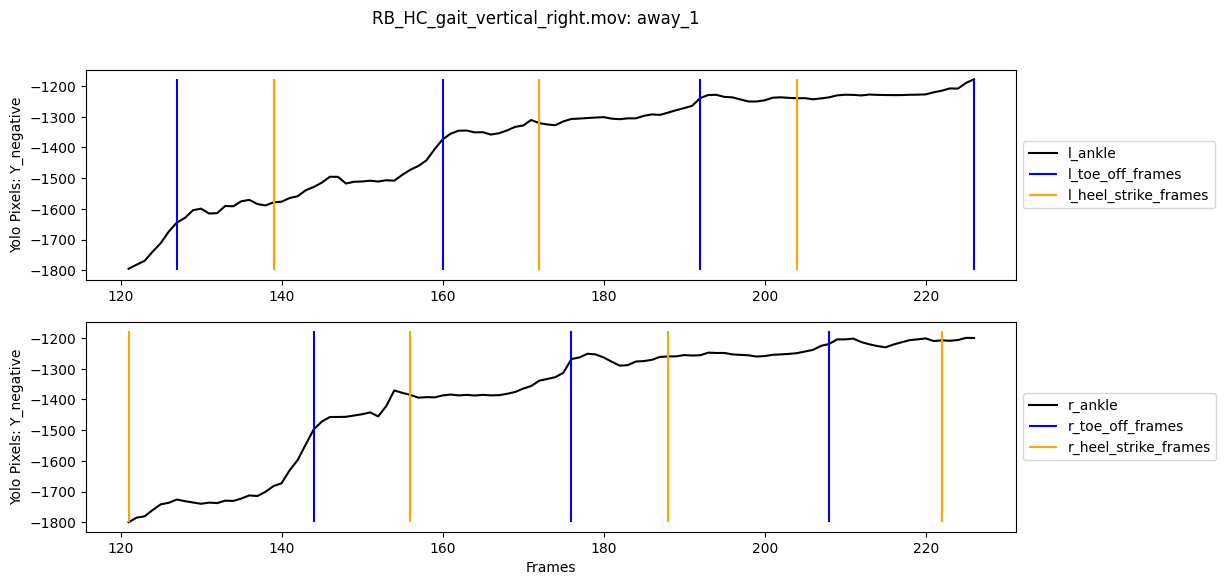

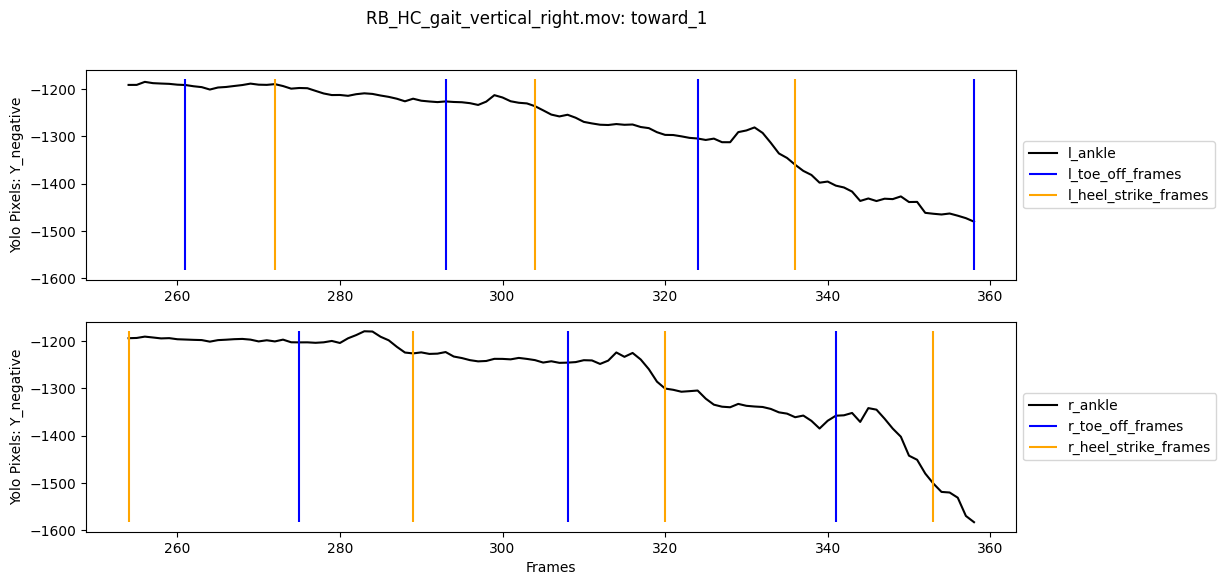

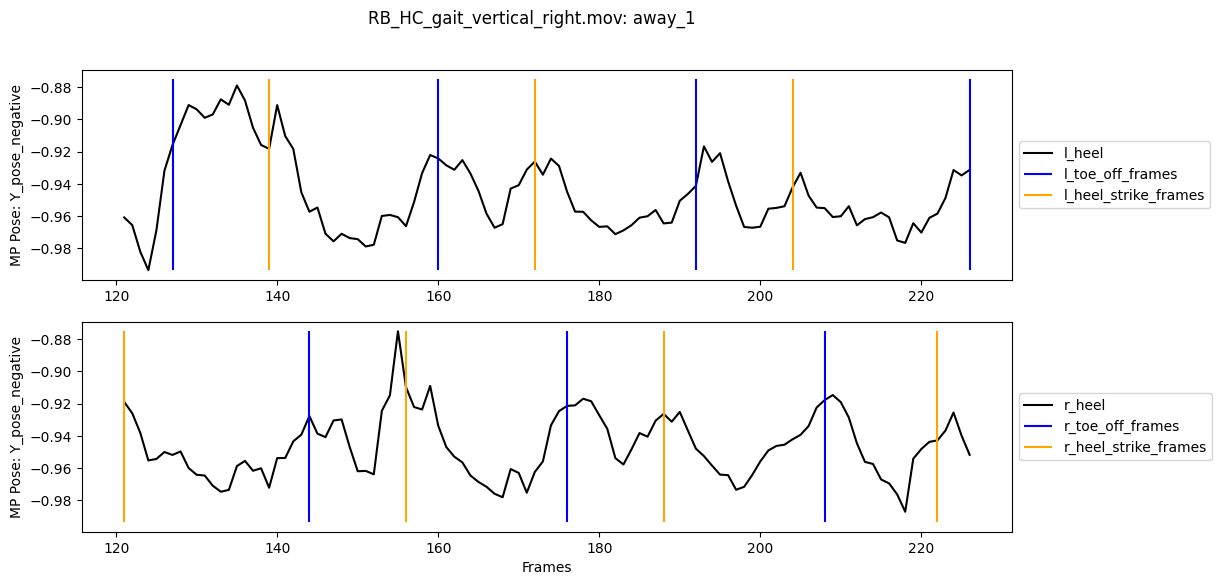

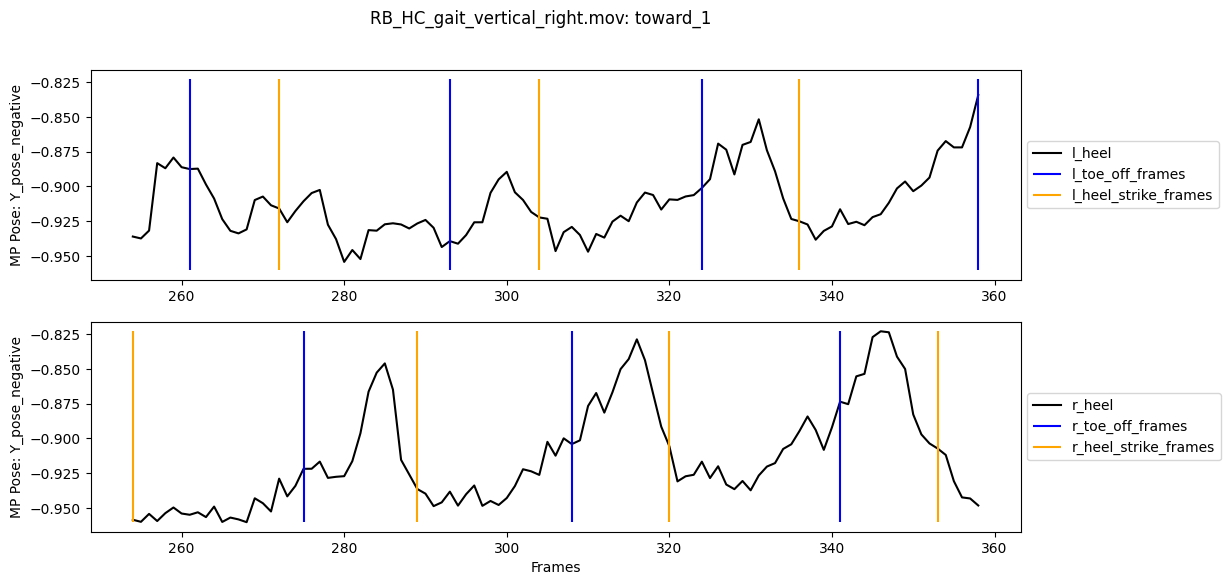

In [13]:
double_support_brainstorming_plots(yolo_df, 'yolo', ground_truth_support_df, vid_in_path, output_parent_folder)
double_support_brainstorming_plots(mp_all_df, 'mediapipe', ground_truth_support_df, vid_in_path, output_parent_folder)

In [ ]:
# TBD if time - gradients and acceleration 

In [6]:
# acceleration of l and r pose 

## try smoothing pose then gradient??


heel_l_df_2_gradient = np.gradient(heel_l_df_2['Y'])
heel_l_df_2_gradient = pd.Series(heel_l_df_2_gradient)
heel_l_df_2_gradient.index = heel_l_df_2['frame']

heel_r_df_2_gradient = np.gradient(heel_r_df_2['Y'])
heel_r_df_2_gradient = pd.Series(heel_r_df_2_gradient)
heel_r_df_2_gradient.index = heel_r_df_2['frame']

# get max and min for ylim of plot 
max_y_gradient = max(max(heel_l_df_2_gradient), max(heel_r_df_2_gradient))
min_y_gradient = min(min(heel_l_df_2_gradient), min(heel_r_df_2_gradient))

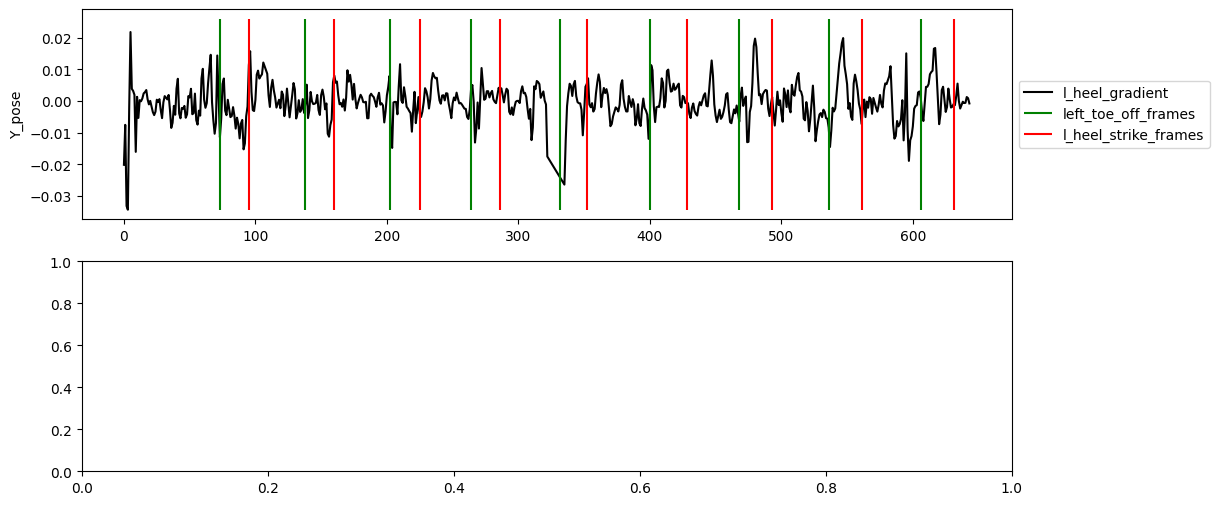

In [7]:
# plot acceleration 

fig2, (ax1, ax2) = plt.subplots(2, figsize=(12, 6))

ax1.plot(heel_l_df_2['frame'], heel_l_df_2_gradient, color = 'black', label = 'l_heel_gradient')
ax1.vlines(x = l_toe_off_frames, ymin = min_y_gradient, ymax = max_y_gradient, color = 'green', label = 'left_toe_off_frames')
ax1.vlines(x = l_heel_strike_frames, ymin = min_y_gradient, ymax = max_y_gradient, color = 'red', label = 'l_heel_strike_frames')
ax1.set_ylabel('Y')
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))